# Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA


# Read the data 

In [2]:
# Read the data
df = pd.read_csv(r'segmentation data.csv')

In [3]:
df

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,100001996,1,0,47,1,123525,0,0
1996,100001997,1,1,27,1,117744,1,0
1997,100001998,0,0,31,0,86400,0,0
1998,100001999,1,1,24,1,97968,0,0


# Data Exploratory 

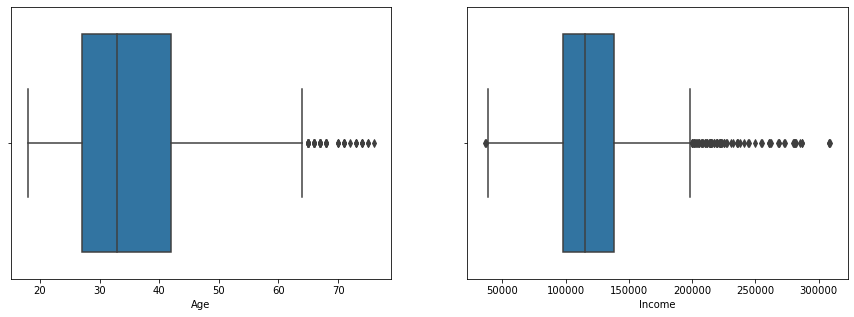

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.boxplot(x=df["Age"], ax=axes[0])
sns.boxplot(x=df["Income"], ax=axes[1])
plt.show()

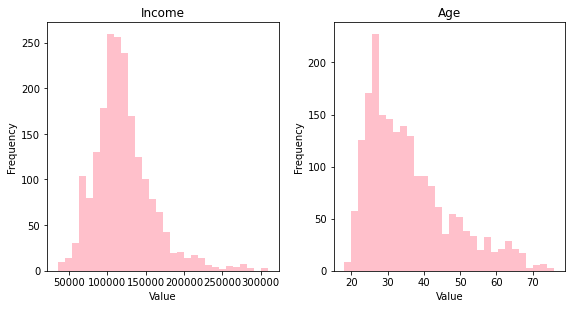

In [5]:
plt.figure(figsize=(16, 8))
attributes = ['Income', 'Age']
for i, attr in enumerate(attributes, 1):
    plt.subplot(2, 4, i)
    plt.hist(df[attr], bins=30, color='pink', alpha=1)
    plt.title(f'{attr}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

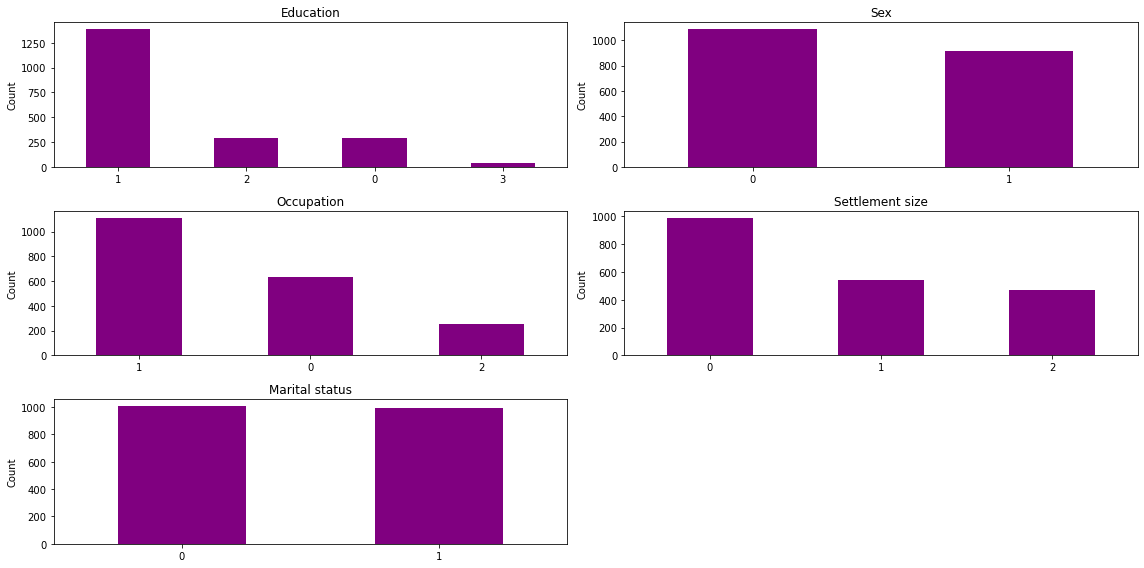

In [6]:
# Bar plots for categorical features
plt.figure(figsize=(16, 8))
attributes = ['Education', 'Sex', 'Occupation', 'Settlement size', 'Marital status']
for i, attr in enumerate(attributes, 1):
    plt.subplot(3, 2, i)
    df[attr].value_counts().plot(kind='bar', color='purple', alpha=1)
    plt.title(f'{attr}')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Data pre-processing 

In [7]:
df = df.drop("ID", axis=1)

In [8]:
df.duplicated().sum()

0

In [9]:
df.isna().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [10]:
scaler = RobustScaler()
scaled_values = scaler.fit_transform(df[['Age', 'Income']])
df[['Age', 'Income']] = scaled_values

In [11]:
df['Occupation'] = df['Occupation'].replace({1: 2})

In [12]:
df['Education'] = df['Education'].replace({3:2,0:3})

In [13]:
def replace_outliers_with_median(df, col_name, threshold=1):
    median = df[col_name].median()
    mad = np.abs(df[col_name] - median).median()
    threshold_value = threshold * mad
    df.loc[np.abs(df[col_name] - median) > threshold_value, col_name] = median
    return df

df = replace_outliers_with_median(df, 'Income')
df = replace_outliers_with_median(df, 'Age')


# Modeling

Model1 (k-means)

C:\Users\Bassant\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


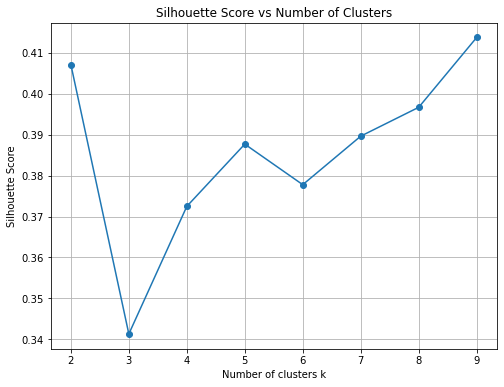

C:\Users\Bassant\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Silhouette Score for k=9: 0.6237216773104244


In [14]:
# K-means clustering
sse = []
sil_scores = []
list_k = list(range(1, 10))
for k in list_k:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)
    if k > 1:
        score = silhouette_score(df, kmeans.labels_)
        sil_scores.append(score)

# Find best k
best_k = list_k[np.argmax(sil_scores) + 1]  # +1 because list_k starts from 1, not 0

# Visualization of silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(list_k[1:], sil_scores, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score vs Number of Clusters")
plt.grid(True)
plt.show()


# Perform k-means clustering with the best_k
kmeans = KMeans(n_clusters=best_k, init='k-means++', n_init=14, max_iter=600, tol=0.0001, verbose=0, random_state=1, algorithm='full')
kmeans.fit(df)
df["Cluster"] = kmeans.labels_

# Silhouette score for the best 'k'
sil_score = silhouette_score(df, kmeans.labels_)
print(f"Silhouette Score for k={best_k}: {sil_score}")



<AxesSubplot:>

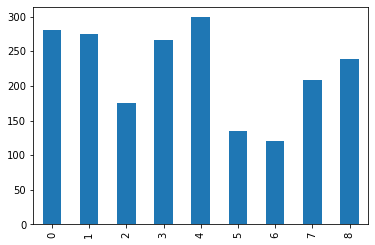

In [15]:
df['Cluster'].value_counts().sort_index().plot(kind='bar')

C:\Users\Bassant\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Bassant\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


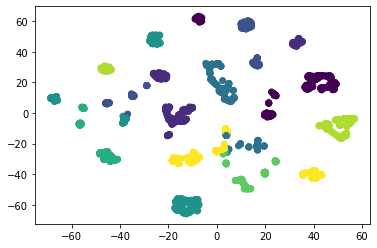

In [16]:
tsne = TSNE(n_components=2).fit_transform(df.drop('Cluster', axis=1))
plt.scatter(tsne[:, 0], tsne[:, 1], c=df['Cluster'])

Moldel2 (k-medoids)

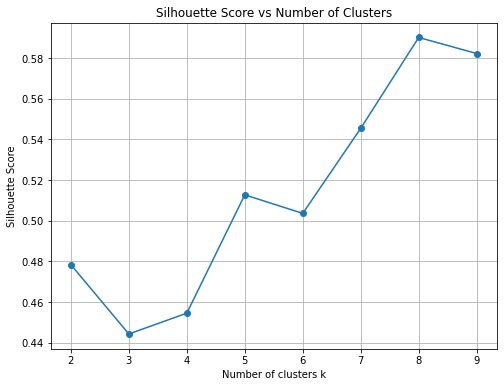

Silhouette Score for k=8: 0.6007330260789687


In [17]:
# KMedoids clustering
sse = []
sil_scores = []
list_k = list(range(1, 10))

for k in list_k:
    kmedoids = KMedoids(n_clusters=k, metric='euclidean', init='k-medoids++', random_state=1)
    kmedoids.fit(df)
    sse.append(kmedoids.inertia_)
    if k > 1:
        score = silhouette_score(df, kmedoids.labels_)
        sil_scores.append(score)

# Find best k
best_k = list_k[np.argmax(sil_scores) + 1]

# Visualization of silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(list_k[1:], sil_scores, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score vs Number of Clusters")
plt.grid(True)
plt.show()


# Perform KMedoids clustering with the best_k
kmedoids = KMedoids(n_clusters=best_k, metric='euclidean', init='k-medoids++', random_state=1, max_iter=300)
kmedoids.fit(df)
df["Cluster"] = kmedoids.labels_

# Silhouette score for the best 'k'
sil_score = silhouette_score(df, kmedoids.labels_)
print(f"Silhouette Score for k={best_k}: {sil_score}")




<AxesSubplot:>

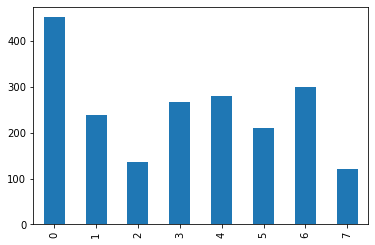

In [18]:
df['Cluster'].value_counts().sort_index().plot(kind='bar')


Model3 (DBSCAN)

In [19]:
# Create a DBSCAN clusterer. You can adjust eps and min_samples as required.
dbscan = DBSCAN(eps=0.3, min_samples=4)

# Fit the scaled data
clusters = dbscan.fit_predict(df)

# Add cluster assignment back to your DataFrame
df['Cluster'] = clusters


In [20]:
# Calculate silhouette score. Note that noise points are also considered in silhouette score.
silhouette_avg = silhouette_score(df, clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")


Silhouette Score: 0.8365


<AxesSubplot:>

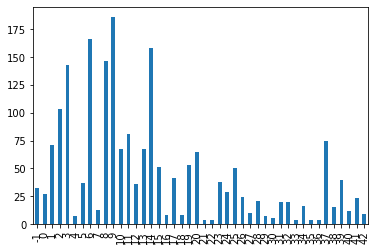

In [21]:
df['Cluster'].value_counts().sort_index().plot(kind='bar')

C:\Users\Bassant\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Bassant\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


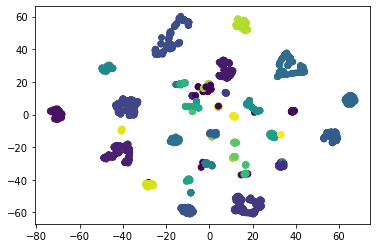

In [22]:
tsne = TSNE(n_components=2).fit_transform(df.drop('Cluster', axis=1))
plt.scatter(tsne[:, 0], tsne[:, 1], c=df['Cluster'])
